# Сегодня мы обойдемся без DeepPavlov

In [71]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

import matplotlib.pyplot as plt



In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


In [73]:
df = pd.read_csv("Log.dms", sep='\t')

In [74]:
df.request = df.request.replace({"https://yandex\.ru/search/\?text=":""}, regex=True)
df["text"] = df["request"].map(str) + df["urls"].map(str)

In [75]:
df.head()

,timestamp,datetime,device,numdoc,region,request,urls,text
0,1520974800,2018-03-14 00:00,desktop,317731505,6,порно видео секс за деньги,http://porno-sex-video.com/eroticheskie-filmy-...,порно видео секс за деньгиhttp://porno-sex-vid...
1,1520974800,2018-03-14 00:00,desktop,277053268,191,sad story скачать бесплатно mp3 в хорошем каче...,http://mp3party.net/music/8507899;http://muz-c...,sad story скачать бесплатно mp3 в хорошем каче...
2,1520974800,2018-03-14 00:00,touch,19987730,2,ольгино баня&flag=l6707,http://www.bani.spb.ru/olgino.html;https://sau...,ольгино баня&flag=l6707http://www.bani.spb.ru/...
3,1520974800,2018-03-14 00:00,touch,196215754,26955,фирменный магазин марко в г минске скидки акции,http://www.marko.by/actions/;https://marko.vit...,фирменный магазин марко в г минске скидки акци...
4,1520974800,2018-03-14 00:00,desktop,3909882795,101704,порно&rl=313,http://porno365.xxx/;https://prostoporno.sex/c...,порно&rl=313http://porno365.xxx/;https://prost...


In [76]:
len(df)

1333503

Интернет нужен для порно :)

А поскольку оно не идет по ТВ, значит все, что попадает сюда — точно не относится к ТВ.

In [103]:
pron_keywords = ['porn', 'порн', 'xxx']
pron = df.text.str.contains("|".join(pron_keywords), na=False)
pron = pron.replace(True, -1)
pron = pron.replace(False, 0)
len(pron[pron == -1])

51640

In [104]:
df["pron"] = pron


Без обучающей выборки будем искать по ключевым словам

In [120]:
other_keywords = ["скачать", "mp3", "facebook.com", "vk.com", "погода", "читать", "maps", "купить"]
tv_keywords = [".tv", "tv.ru", "сериал"]

0    0.0
1   -1.0
2    0.0
3    0.0
4    0.0
Name: text, dtype: float64
1333503


text,-1.0,0.0
text,,
-1.0,215953,0
0.0,0,1117550


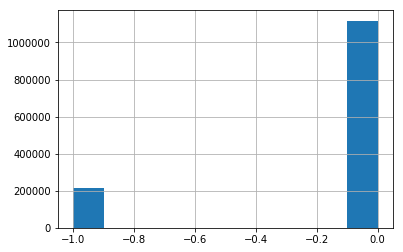

In [125]:
other = df.text.str.contains("|".join(other_keywords), na=False)
other = other.replace(True, -1)
other = other.replace(False, 0)
#other = other.astype('bool')
print(other.head())
print(len(other))
other.hist()
pd.crosstab(other, other)

0    0
1    0
2    0
3    0
4    0
Name: text, dtype: int64
1333503


text,0,1
text,,
0,1131378,0
1,0,202125


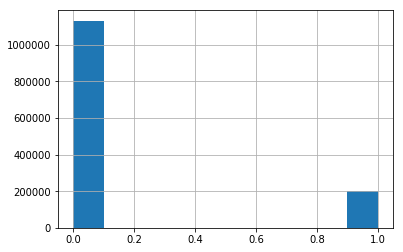

In [126]:
tv = df.text.str.contains("|".join(tv_keywords), na=False)
tv = tv.astype('int')



print(tv.head())
print(len(tv))
tv.hist()

pd.crosstab(tv, tv)

In [127]:
tv_column = tv + other + pron
tv_column = tv_column.replace(-2,-1)
#tv_column = tv_column.replace(0,np.NaN)
df["tv"] = tv_column
pd.crosstab(df["tv"], df["tv"])

tv,-1.0,0.0,1.0
tv,,,
-1.0,237454,0,0
0.0,0,922172,0
1.0,0,0,173877


In [128]:
train = df[df["tv"].notnull()]

In [129]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=1000,
                                   stop_words=['english','russian']
                                  )

tfidf = tfidf_vectorizer.fit_transform(train["request"])


In [130]:
tfidf.shape

(1333503, 1000)

In [131]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(tfidf, train["tv"])

In [132]:
test_new = ['tv.is', 'Random flood?', "mp3"]
test_new_tfidf = tfidf_vectorizer.transform(test_new)

predicted = clf.predict(test_new_tfidf)
predicted

for doc, category in zip(test_new, predicted):
     print('%r => %s' % (doc, category))

'tv.is' => 1.0
'Random flood?' => 0.0
'mp3' => -1.0


In [153]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# text_clf = Pipeline([('tfidf_std', tfidf_vectorizer),
#                      ('clf', SGDClassifier(random_state=42, max_iter=5)),
# ])
text_clf = Pipeline([('tfidf_std', tfidf_vectorizer),
                     ('clf', CalibratedClassifierCV()),
])
text_clf.fit(train["text"], train["tv"])

Pipeline(memory=None,
     steps=[('tfidf_std', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tr...ue, vocabulary=None)), ('clf', CalibratedClassifierCV(base_estimator=None, cv=3, method='sigmoid'))])

In [134]:
predicted = text_clf.predict(train["text"])

In [135]:
np.mean(predicted == train["tv"])   

0.8822589825444712

In [154]:
from sklearn import metrics
print(metrics.classification_report(train["tv"], predicted))

             precision    recall  f1-score   support

       -1.0       0.94      0.81      0.87    237454
        0.0       0.87      0.98      0.92    922172
        1.0       0.91      0.47      0.62    173877

avg / total       0.89      0.88      0.87   1333503



In [155]:
predicted = text_clf.predict(df["text"])


In [156]:
predict_proba

array([[7.98855787e-01, 2.01144213e-01, 1.72229569e-10],
       [9.98287816e-01, 1.71186879e-03, 3.15535073e-07],
       [2.24306393e-02, 9.29609471e-01, 4.79598902e-02],
       ...,
       [6.84186867e-03, 9.48051402e-01, 4.51067297e-02],
       [8.82505207e-03, 9.11672753e-01, 7.95021953e-02],
       [2.02681631e-02, 9.30375944e-01, 4.93558925e-02]])

In [138]:
df["tv_final"] = predicted + df["tv"]

In [139]:
pd.crosstab(df["tv_final"], df["tv_final"])

tv_final,-2.0,-1.0,0.0,1.0,2.0
tv_final,,,,,
-2.0,192828,0,0,0,0
-1.0,0,56749,0,0,0
0.0,0,0,902253,0,0
1.0,0,0,0,100052,0
2.0,0,0,0,0,81621


In [202]:
df["tv_final"].value_counts(normalize = True)

 0.0    0.676604
-2.0    0.144603
 1.0    0.075029
 2.0    0.061208
-1.0    0.042556
Name: tv_final, dtype: float64

Всего связано с TV как минимум 12% запросов. Но, возможно, из оставшихся 67% есть еще...

In [150]:
df[df["tv_final"] >= 2].request.head()

5     нужно ли мыть гречку перед варкой&id=hYYVGyK1c...
15                                   тильтовать что это
17                             футбол 1 смотреть онлайн
47    и всётаки я люблю все серии подряд онлайн бесп...
61      смотреть онлайн матч футбол 1 прямая трансляция
Name: request, dtype: object

In [149]:
df[df["tv_final"] <= -2].request.head()

0                            порно видео секс за деньги
1     sad story скачать бесплатно mp3 в хорошем каче...
4                                          порно&rl=313
14                                        Limesmedia.ru
21                   работа студентов Вив&client=916571
Name: request, dtype: object

In [184]:
tfidf_results = text_clf.steps[0][1].transform(df[df["tv_final"] == 2]["request"])

        


In [193]:
def tfidf_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    results = []
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores:
        results.append("{0:50} Score: {1}".format(item[0], item[1]))
    return results
tfidf_scores(text_clf.steps[0][1], tfidf_results)[:50]

['flag                                               Score: 11257.616435245052',
 'client                                             Score: 6721.360098310816',
 'rl                                                 Score: 6656.546956663611',
 'id                                                 Score: 6520.615736789215',
 'сериал                                             Score: 5378.381599753146',
 'смотреть                                           Score: 4237.786190235142',
 'на                                                 Score: 3823.052927587481',
 'онлайн                                             Score: 3418.8215052229934',
 'как                                                Score: 2978.4884755996086',
 'сезон                                              Score: 2903.356504026397',
 'фильм                                              Score: 2725.850228752163',
 'что                                                Score: 2280.5322276367265',
 '2017                              